In [1]:
from transformers import ViTFeatureExtractor
import requests
from PIL import Image

import torch
import numpy as np
import matplotlib.pyplot as plt

from transformers import ViTMAEForPreTraining

/u/home/bue/.virtualenvs/idp/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


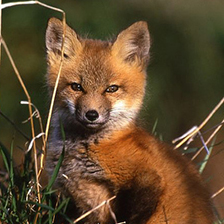

In [2]:
feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")
url = "https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [3]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
pixel_values.size()

torch.Size([1, 3, 224, 224])

In [66]:
imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    print("pixel_values:", pixel_values.size())
    outputs = model(pixel_values)
    print("outputs:", outputs.logits.size())
    y = model.unpatchify(outputs.logits)
    print("y:", y.size())
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    print("y:", y.size())

    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

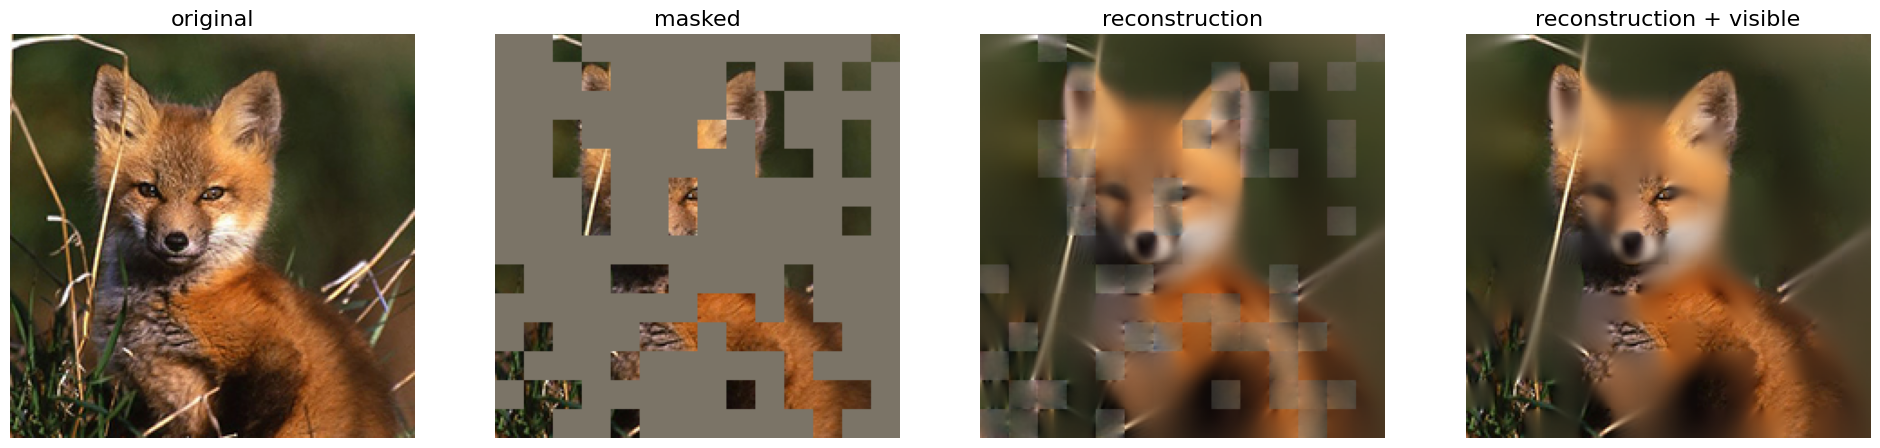

In [5]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

visualize(pixel_values, model)

In [6]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained("facebook/vit-mae-base")

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# IRMA

In [47]:
from torchvision import transforms

In [7]:
%load_ext autoreload
%autoreload 2
from irma_dataset import Irma

In [8]:
data_path = "/u/home/bue/deployment/data/IRMA/"
dataset = Irma(root=data_path)
dataset.load()

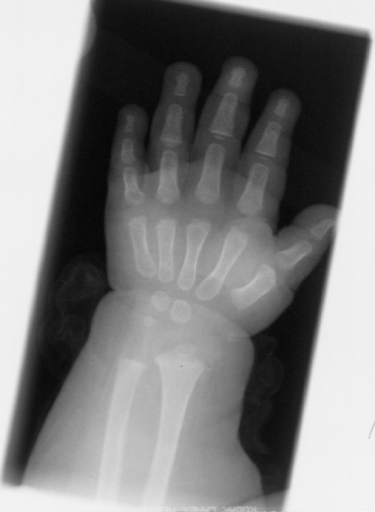

In [53]:
sample = dataset.df.iloc[42]
image = dataset.load_image(sample["Path"])
image

In [54]:
image.size

(375, 512)

In [55]:
image_size = 224

In [57]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((image_size, image_size))])
x = transform(image)
x.size()

torch.Size([3, 224, 224])

In [60]:
pixel_values = feature_extractor(x, return_tensors="pt", do_rescale=False).pixel_values
pixel_values.size()

torch.Size([1, 3, 224, 224])

pixel_values: torch.Size([1, 3, 224, 224])
outputs: torch.Size([1, 196, 768])
y: torch.Size([1, 3, 224, 224])
y: torch.Size([1, 224, 224, 3])


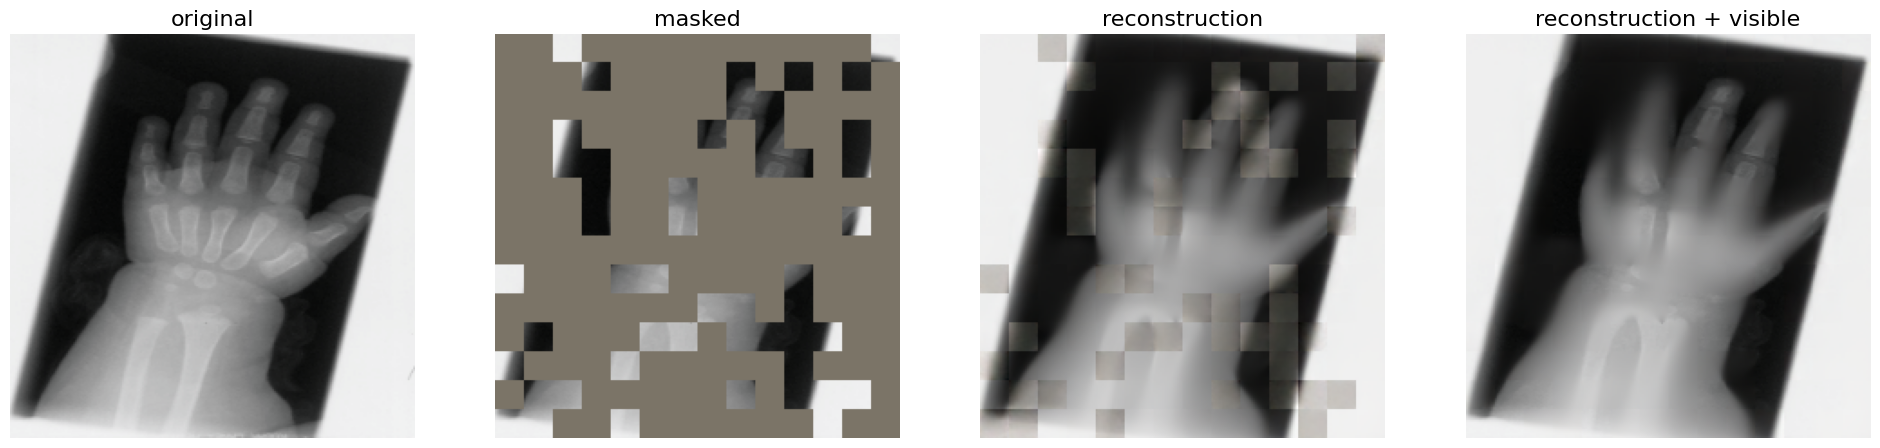

In [67]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

visualize(pixel_values, model)